# Wer hat auf Untappd die Nase vorn
Eine kleine Datenalyse der Schweizer Biere und Brauereien auf Untappd.

In [45]:
import pandas as pd
import re
import time
import random
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams.update(
    {"figure.facecolor": "#ffffff",
              "axes.facecolor": "#ffffff",
              "axes.grid" : True,
              "axes.grid.axis" : "y",
              "grid.color"    : "ededed",
              "grid.linewidth": 0.8,
              "grid.alpha": 0.8,
              "axes.spines.left" : False,
              "axes.spines.right" : False,
              "axes.spines.top" : False,
              "axes.spines.bottom" : False,
              "axes.axisbelow": False,
              "ytick.major.size": 0,     
              "ytick.minor.size": 0,
              #"xtick.direction" : "none",
              "xtick.minor.size": 0,
              "xtick.major.size" : 0,
              "xtick.color"      : "#191919",
              "axes.edgecolor"    :"#191919",
              "axes.prop_cycle" : plt.cycler('color', ['#0c2c84', '#c7e9b4', 
                                                       '#225ea8','#1d91c0', '#41b6c4', 
                                                       '#7fcdbb', '#eaea8c']),
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Datenbereinigung

In [4]:
#Lese gescrapte Datensätze ein
df_breweries = pd.read_csv('schweizer_brauereien_untappd.csv')
df_beers = pd.read_csv('schweizer_biere_untappd.csv')
#Merge die beiden Datensätze
df = df_breweries.merge(df_beers, on='link')

In [5]:
#Alle Biere, die kein Rating haben löschen
df = df[~(df['beer_rating'] == '(N/A)')]

In [6]:
#Bereinigung der Ratings und der Zahl der Ratings
df['beer_rating'] = df.beer_rating.str.replace('(', '')
df['beer_rating'] = df.beer_rating.str.replace(')', '')
df['beer_rating'] = df.beer_rating.astype(float)
df['raters'] = df.raters.str.replace(' Ratings', '')
df['raters'] = df.raters.str.replace(',', '')
df['raters'] = df.raters.astype(int)
df['brewery_rating'] = df.rating.str.replace('(', '')
df['brewery_rating'] = df.brewery_rating.str.replace(')', '')
df['brewery_rating'] = df.brewery_rating.astype(float)
df['brewery_no_rating'] = df.no_ratings.str.replace(',', '')
df['brewery_no_rating'] = df.brewery_no_rating.str.replace(' Ratings', '')
df['brewery_no_rating'] = df.brewery_no_rating.astype(int)
#Alkoholgehalt extrahieren
df['alk'] = df.abv.str.extract('(\d*.\d*)% ABV').astype(float)

In [7]:
#Städte und Kantone extrahieren
df['city'] = df.location.str.extract('(.*), .* Switzerland')
df['canton'] = df.location.str.extract('.*, (.*) Switzerland')
#Zürich wird unterschiedlich geschrieben, vereinheitlichen
df['canton'] = df.canton.str.replace('Zurich', 'Zürich')
print(len(df.canton.value_counts()),'Kantone sind im Datensatz')

26 Kantone sind im Datensatz


Problem: Einige Brauereien haben keinen Kanton erfasst auf Untappd. Daher braucht es eine manuelle Bereinigung. 
Eine Brauerei muss dann bereinigt werden, wenn sie für Analyse relevant ist: Für Top-Listen braucht es gemäss Untappd mindestens 1000 Bewertungen für eine Brauerei, oder mindestens 150 für ein spezifisches Bier. Erfüllt eine Brauerei eines diese Kriterien, hat aber keinen Kanton, wird sie nachgeführt.

In [8]:
#df[df['canton'].isna()].sort_values('raters',ascending=False)[['name','beer_name','raters']].head(50)
#df[df['canton'].isna()].sort_values('brewery_no_rating',ascending=False)[['name','brewery_no_rating']].drop_duplicates().head(15)

In [46]:
#Bereinigung ausgewählter Brauerein, die keinen Kanton haben.
print(len(df[df['canton'].isna()].sort_values('brewery_no_rating',ascending=False)[['name','brewery_no_rating']].drop_duplicates()), 'Brauereien haben keinen Kanton')
df['canton'][df['name']=='Falken'] = 'Schaffhausen'
df['canton'][df['name']=='Sudwerk Brauerei'] = 'Zürich'
df['canton'][df['name']=='Öufi Brauerei Solothurn'] = 'Solothurn'
df['canton'][df['name']=='Nordwand Bräu'] = 'Bern/Berne'
df['canton'][df['name']=='Broken City Brewing'] = 'Ticino'
df['canton'][df['name']=='Federation of Malted Republics (FMR)'] = 'Solothurn'
df['canton'][df['name']=='Brauerei Oerlikon'] = 'Zürich'
df['canton'][df['name']=='Emdbräu'] = 'Schwyz'
df['canton'][df['name']=='Coop'] = 'Basel-Stadt'
df['canton'][df['name']=='Valora Holding AG'] = 'Basel-Landschaft'
df['canton'][df['name']=='Denner'] = 'Zürich'
df['canton'][df['name']=='Volg'] = 'Zürich'
df['canton'][df['name']=='Drinks of the World'] = 'Zürich'
df['canton'][df['name']=='The Alps'] = 'Valais/Wallis'
df['canton'][df['name']=='Stammheimer Hopfentropfen'] = 'Zürich'
df['canton'][df['name']=='Komturei Tobel'] = 'Thurgau'
df['canton'][df['name']=="Cap'taine Mousse"] = 'Vaud'

#### Achtung: Glatteis

In Rücksprache mit diversen Bier-Nerds habe ich eine nicht abschliessende Kategorisierung gängiger Biersorten vorgenommen, die uns eine Annäherung an eine Bierstil-Analyse ermöglicht. Diese liesses sich beliebig erweitern und wohl auch anders einteilen. Wir haben uns hierfür entschieden, und sind einigermassen ok damit.

In [47]:
df['style'] = 'other'
#drop Cider
df['style'][df['beer_stye'].str.contains('Cider')] = 'cider'
df = df[df['style']!='cider']
## Kategorisiere die Biere
df['style'][df['beer_stye'].str.contains('weizen')] = 'Weizen'
df['style'][df['beer_stye'].str.contains('Wheat')] = 'Weizen'
df['style'][df['beer_stye'].str.contains('IPA')] = 'IPA & PA'
df['style'][df['beer_stye'].str.contains('Pale Ale')] = 'IPA & PA'
df['style'][df['beer_stye'].str.contains('English Bitter')] = 'IPA & PA'
df['style'][df['beer_stye'].str.contains('Extra Special')] = 'IPA & PA'
df['style'][df['beer_stye'].str.contains('Belgian')] = 'Belgian'
df['style'][df['beer_stye'].str.contains('Bière Brut')] = 'Belgian'
df['style'][df['beer_stye'].str.contains('Witb')] = 'Belgian'
df['style'][df['beer_stye'].str.contains('Farmhouse Ale')] = 'Belgian'
df['style'][df['beer_stye'].str.contains('Bière de Garde')] = 'Belgian'
df['style'][df['beer_stye'].str.contains('Sour')] = 'Sour'
df['style'][df['beer_stye'].str.contains('Fruit')] = 'Sour'
df['style'][df['beer_stye'].str.contains('Lambic')] = 'Sour'
df['style'][df['beer_stye'].str.contains('Brett')] = 'Sour'
df['style'][df['beer_stye'].str.contains('Geuze')] = 'Sour'
df['style'][df['beer_stye'].str.contains('Grape')] = 'Sour'
df['style'][df['beer_stye'].str.contains('American Wild Ale')] = 'Sour'
df['style'][df['beer_stye'].str.contains('Lager')] = 'Lager & Pilsner'
df['style'][df['beer_stye'].str.contains('Pilsner')] = 'Lager & Pilsner'
df['style'][df['beer_stye'].str.contains('Stout')] = 'Stout/Porter'
df['style'][df['beer_stye'].str.contains('Porter')] = 'Stout/Porter'

print(df['style'].value_counts())
#list(set(df[df['style']=='other']['beer_stye']))

# Analysen der Daten

In [17]:
#Welche Bierstile erhalten durchschnittlich die besten Bewertungen
df.groupby('style').beer_rating.median().sort_values(ascending=False)

style
Sour               3.69
Stout/Porter       3.59
IPA & PA           3.58
Belgian            3.50
Weizen             3.40
other              3.38
Lager & Pilsner    3.28
Name: beer_rating, dtype: float64

In [12]:
#Welches sind die besten Biere der Schweiz
#Funktion, die einem abhängig von einer Mindestanzahl Ratings die Top X zurückgibt
def get_best_beer(data, minimumraters,top):
    subset = data[(data['raters']>=minimumraters)].sort_values('beer_rating', ascending=False).head(top)
    return subset[['beer_name','name','beer_rating','raters']]

In [164]:
top_beers = get_best_beer(df,150,20)
top_beers

,beer_name,name,beer_rating,raters
18,Abbaye de Saint Bon-Chien Grand Cru - Special ...,Brasserie des Franches-Montagnes (BFM),4.28,693
20,Brut des Franches,Brasserie des Franches-Montagnes (BFM),4.23,580
3018,Schwarz Mönch,Schwarz Mönch,4.22,566
0,Abbaye de Saint Bon-Chien,Brasserie des Franches-Montagnes (BFM),4.17,27817
19,√400 Saison 20th Anniversary Special Edition I...,Brasserie des Franches-Montagnes (BFM),4.16,698
1376,Coetus,Brasserie L'Apaisée,4.13,167
689,Fleur de Sureau,À tue-tête,4.12,169
690,Noire Cassis,À tue-tête,4.10,150
16,Jeandy Paplus 10th Anniversary Moeder Lambic O...,Brasserie des Franches-Montagnes (BFM),4.08,761
681,Pêche Abricot,À tue-tête,4.08,475


In [19]:
#Welches sind die besten Biere pro Kanton
#Funktion, die einem abhängig von einer Mindestanzahl Ratings die Top X pro Kanton zurückgibt
def get_best_beer_canton(data, canton, minimumraters,top):
    subset = data[(data['raters']>=minimumraters) & (data['canton']==canton)].sort_values('beer_rating', ascending=False).head(top)
    return subset[['beer_name','name','beer_rating','raters']]

In [49]:
top_beer_ct = get_best_beer_canton(df,'Zürich',150,20)
top_beer_ct

,beer_name,name,beer_rating,raters
406,Beast,S&A Brewing,3.99,356
411,Down Range,S&A Brewing,3.91,247
412,Haze Case: N.E.IPA VII,S&A Brewing,3.89,270
416,Vanilla Sky,S&A Brewing,3.87,235
414,Citra Saison,S&A Brewing,3.85,165
418,Milk Shout,S&A Brewing,3.81,202
408,"In A Galaxy Far, Far Away",S&A Brewing,3.81,256
1630,India Pale Ale,Braumanufaktur Schlachthuus,3.80,241
427,Too Easy,S&A Brewing,3.78,150
430,Pale Galaxy,S&A Brewing,3.76,155


In [21]:
#Welches sind die besten Brauereien
#Funktion, die einem abhängig von einer Mindestanzahl Ratings die Top X zurückgibt
def get_best_brewery(data, minimumraters, top):
    subset = data[(data['brewery_no_rating']>=minimumraters)].sort_values('brewery_rating', ascending=False)
    subset = subset[['name','canton','brewery_rating','brewery_no_rating']].drop_duplicates()
    subset = subset.head(top)
    return subset

In [23]:
top_brewery = get_best_brewery(df,1000, 20)
top_brewery

,name,canton,brewery_rating,brewery_no_rating
0,Brasserie des Franches-Montagnes (BFM),Jura,3.970,138634
2110,nine brothers,Bern/Berne,3.956,1155
1386,Brasserie L'Apaisée,Genève,3.909,2361
686,À tue-tête,Vaud,3.908,5846
1121,Cinq 4000,Valais/Wallis,3.882,3460
1571,Cayon's,Vaud,3.789,1981
429,S&A Brewing,Zürich,3.770,9624
88,Trois Dames,Vaud,3.730,55938
1185,Barbière,Bern/Berne,3.719,3143
1057,Haarige Kuh Brauerei,Bern/Berne,3.708,3600


In [50]:
#Welches sind die besten Brauereien pro Kanton
#Funktion, die einem abhängig von einer Mindestanzahl Ratings die Top X pro Kanton zurückgibt
def get_best_brewery_canton(data, canton, minimumraters, top):
    subset = data[(data['brewery_no_rating']>=minimumraters) & (data['canton']==canton)].sort_values('brewery_rating', ascending=False)
    subset = subset[['name','brewery_rating','canton','brewery_no_rating']].drop_duplicates()
    subset = subset.head(top)
    return subset

In [163]:
top_brewery_ct = get_best_brewery_canton(df,'Zürich',1000, 10)
top_brewery_ct

,name,brewery_rating,canton,brewery_no_rating
430,S&A Brewing,3.770,Zürich,9624
1475,Brausyndikat,3.567,Zürich,2176
1853,Ahoi Bier,3.566,Zürich,1552
1507,St. Laurentius,3.558,Zürich,2124
1415,Bear'n'Stein,3.557,Zürich,2276
1637,Braumanufaktur Schlachthuus,3.552,Zürich,1729
1907,The Darkwolf Brewery,3.490,Zürich,1502
126,Doppelleu Brauwerkstatt,3.430,Zürich,34363
926,Dr. Brauwolf,3.423,Zürich,4075
1073,Sudwerk Brauerei,3.408,Zürich,3598


In [39]:
#Loope für die Top 10 (wenn es dann so viele gibt mit X Bewertungen) aller Kantone
#kantoene = list(set(df.canton.dropna()))
#topbreweries_ct = pd.DataFrame()
#for kanton in kantoene:
#    top_brewery_ct = get_best_brewery_canton(df,kanton,1000, 10)
#    topbreweries_ct = pd.concat([topbreweries_ct, top_brewery_ct])
#topbreweries_ct

In [40]:
# Wie viele Sterne machen die wirklich auch oft getrunkenen Biere?
print("So schneiden die weit verbreiteten Biere ab:")
print(df[(df['beer_name']=='Original')&(df['name']=='Feldschlösschen')].beer_rating.iloc[0], '* hat das Feldschlösschen Original + ', df[(df['beer_name']=='Original')&(df['name']=='Feldschlösschen')].raters.iloc[0], 'Ratings')
print(df[(df['beer_name']=='Appenzeller Quöllfrisch Hell')&(df['name']=='Brauerei Locher')].beer_rating.iloc[0], '* hat das  Appenzeller Quöllfrisch Hell')
print(df[(df['beer_name']=='Lager')&(df['name']=='Brauerei Eichhof')].beer_rating.iloc[0], '* hat das Eichhof Lager')
print(df[(df['beer_name']=='Chopfab Draft')&(df['name']=='Doppelleu Brauwerkstatt')].beer_rating.iloc[0], '* hat das Chopfab Draft')
print(df[(df['beer_name']=='Calanda')&(df['name']=='Calanda')].beer_rating.iloc[0], '* hat das Calanda')
print(df[(df['beer_name']=='Lager Hell')&(df['name']=='Schützengarten')].beer_rating.iloc[0], '* hat das Schüga Lager Hell')

So schneiden die weit verbreiteten Biere ab:
2.97 * hat das Feldschlösschen Original +  22597 Ratings
3.16 * hat das  Appenzeller Quöllfrisch Hell
3.05 * hat das Eichhof Lager
3.28 * hat das Chopfab Draft
2.89 * hat das Calanda
2.95 * hat das Schüga Lager Hell


In [41]:
print("So schneiden deren Brauereien:")
print(df[(df['name']=='Feldschlösschen')].brewery_rating.iloc[0], '* hat Feldschlösschen + ', df[(df['beer_name']=='Original')&(df['name']=='Feldschlösschen')].brewery_no_rating.iloc[0], 'Ratings')
print(df[(df['name']=='Brauerei Locher')].brewery_rating.iloc[0], '* hat die Brauerei Locher')
print(df[(df['name']=='Brauerei Eichhof')].brewery_rating.iloc[0], '* hat Eichhof')
print(df[(df['name']=='Doppelleu Brauwerkstatt')].brewery_rating.iloc[0], '* hat Doppelleu Brauwerkstatt')
print(df[(df['name']=='Calanda')].brewery_rating.iloc[0], '* hat Calanda')
print(df[(df['name']=='Schützengarten')].brewery_rating.iloc[0], '* hat Schüga')

So schneiden deren Brauereien:
3.0 * hat Feldschlösschen +  83339 Ratings
3.26 * hat die Brauerei Locher
3.08 * hat Eichhof
3.43 * hat Doppelleu Brauwerkstatt
2.93 * hat Calanda
3.22 * hat Schüga


In [53]:
#Welches sind die besten Biere pro Kanton und Stil
#Funktion, die einem abhängig von einer Mindestanzahl Ratings und dem Bierstil die Top X pro Kanton zurückgibt
#def get_best_beer_canton_style(data, canton, style, minimumraters,top):
#    subset = data[(data['raters']>=minimumraters) & (data['canton']==canton)& (data['style']==style)].sort_values('beer_rating', ascending=False).head(top)
#    return subset[['beer_name','name','beer_rating','style']]
#Welches sind die besten Biere pro Kanton und Stil
#Funktion, die einem abhängig von einer Mindestanzahl Ratings und dem Bierstil die Top X pro Kanton zurückgibt
def get_best_beer_style(data, style, minimumraters,top):
    subset = data[(data['raters']>=minimumraters) & (data['style']==style)].sort_values('beer_rating', ascending=False).head(top)
    return subset[['beer_name','name','beer_rating','style', 'canton']]

In [54]:
#IPA & PA       
#other          
#Lager & Pilsner
#Belgian        
#Stout/Porter   
#Sour           
#Weizen         
get_best_beer_style(df,'IPA & PA',150,10)

,beer_name,name,beer_rating,style,canton
109,Confetti Western,WhiteFrontier,4.02,IPA & PA,Valais/Wallis
406,Beast,S&A Brewing,3.99,IPA & PA,Zürich
107,How Soon Is Now?,WhiteFrontier,3.98,IPA & PA,Valais/Wallis
1373,L'Insolente Double IPA,Brasserie L'Apaisée,3.93,IPA & PA,Genève
113,New England DIPA,WhiteFrontier,3.91,IPA & PA,Valais/Wallis
411,Down Range,S&A Brewing,3.91,IPA & PA,Zürich
24,Highway To Helles Prince De Galles Edition,Brasserie des Franches-Montagnes (BFM),3.89,IPA & PA,Jura
412,Haze Case: N.E.IPA VII,S&A Brewing,3.89,IPA & PA,Zürich
182,Hold'hop,La Nébuleuse,3.88,IPA & PA,Vaud
120,Calypso DIPA,WhiteFrontier,3.88,IPA & PA,Valais/Wallis


### Ein paar grafische Analysen


In [57]:
# Nummerieren der Bierstile, um einen Scatterplot erstellen zu können
df['styleno'] = 0
df['styleno'][df['style'].str.contains('IPA')] = 2
df['styleno'][df['beer_stye'].str.contains('Sour')] = 4
df['styleno'][df['beer_stye'].str.contains('Lager')] = 1
df['styleno'][df['beer_stye'].str.contains('Stout')] = 3

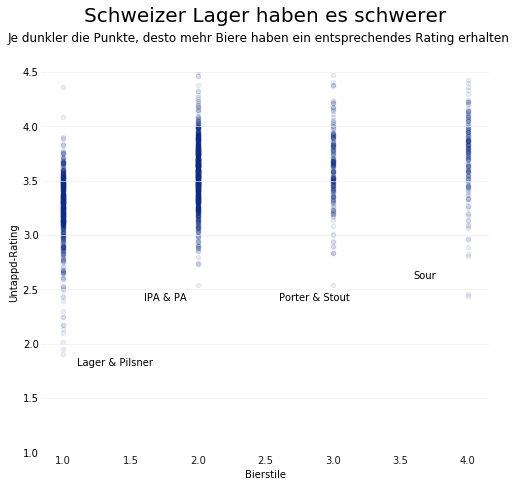

In [152]:
ax =  df[df['styleno']!=0].plot.scatter('styleno', 'beer_rating', figsize=(8,7),alpha=0.08, ylim=(1,4.5))
ax.set_title("Schweizer Lager haben es schwerer", ha='center',pad=50, fontsize=20)
plt.gcf().text(0.5,0.94, "Je dunkler die Punkte, desto mehr Biere haben ein entsprechendes Rating erhalten", ha='center', fontsize=12)

#x-axis
ax.xaxis.label.set_visible(True)
ax.set_xlabel('Bierstile')
ax.grid(False, axis='x')

#-axis
ax.yaxis.label.set_visible(True)
ax.set_ylabel('Untappd-Rating')
ax.grid(True, axis='y')

#text
ax.text(1.1,1.8,"Lager & Pilsner")
ax.text(1.6,2.4,"IPA & PA")
ax.text(2.6,2.4,"Porter & Stout")
ax.text(3.6,2.6,"Sour")
#save
plt.savefig('biertsile.pdf', bbox_inches='tight')

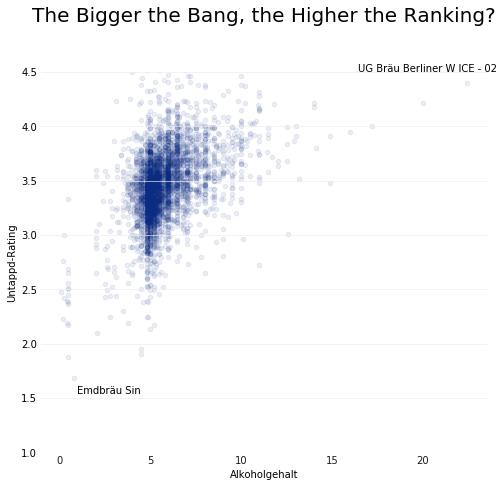

In [167]:
ax =  df.plot.scatter('alk', 'beer_rating', figsize=(8,7),alpha=0.08, ylim=(1,4.5))
ax.set_title("The Bigger the Bang, the Higher the Ranking?", ha='center',pad=50, fontsize=20)
#plt.gcf().text(0.5,0.94, "", ha='center', fontsize=12)

#x-axis
ax.xaxis.label.set_visible(True)
ax.set_xlabel('Alkoholgehalt')
ax.grid(False, axis='x')

#-axis
ax.yaxis.label.set_visible(True)
ax.set_ylabel('Untappd-Rating')
ax.grid(True, axis='y')

#text
ax.text(1,1.54,"Emdbräu Sin")
ax.text(16.4,4.5,"UG Bräu Berliner W ICE - 02")
#save
plt.savefig('alkoholvsrating2.pdf', bbox_inches='tight')